In [10]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn

import sys
sys.path.insert(0, '..') 

In [11]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cuda device


In [30]:
# https://www.ncbi.nlm.nih.gov/protein/CAA25240
# accession CAA25240.1 epidermal growth factor receptor [Homo sapiens]
# uniprotkb P00533
pro_seq = ['MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV',
    'QRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNL',
    'QEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKL',
    'TKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVN',
    'PEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLS',
    'INATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAF',
    'ENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKI',
    'ISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCKLLEGEPREFVENSECIQCHP',
    'ECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVMGENNTLVWKYADAGHVCHLCHPNCTYGCTG',
    'PGLEGCPTNGPKIPSIATGMVGALLLLLVVALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPN',
    'QALLRILKETEFKKIKVLGSGAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVD',
    'NPHVCRLLGICLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAA',
    'RNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSYGVTVWELMTF',
    'GSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPKFRELIIEFSKMARDPQRYLV',
    'IQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQQGFFSSPSTSRTPLLSSLSATSNNSTVACI',
    'DRNGLQSCPIKEDSFLQRYSSDPTGALTEDSIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPS',
    'RDPHYQDPHSTAVGNPEYLNTVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGS',
    'TAENAEYLRVAPQSSEFIGA']
pro_seq = ''.join(pro_seq)
print(len(pro_seq))

1210


## load pre-trained RNN model

In [325]:
from rnn.my_dataset import MyDataset
from rnn.my_collate import MyCollate
from rnn.my_rnn import MyRNN
from rnn.my_process import MyProcess

# load vocab
input_vocab = torch.load('../models/epitopes_rnn_vocab.pth')
vocab_size = len(input_vocab)

model = MyRNN(vocab_size) 
pre_trained =  torch.load('../models/epitopes_rnn.pth', weights_only=True)
model.load_state_dict(pre_trained)
model = model.to(device)
model.eval()

MyRNN(
  (embedding): Embedding(23, 32, padding_idx=0)
  (rnn): LSTM(32, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [326]:
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

num_epochs = 10
p = MyProcess(model, collate_fn, num_epochs)

In [327]:
# test predict
input = [
    # epitopes
    'SSPFLKGFLAGYVVAKLRASAV',
    # non-epitopes exact
    'AELMPVGDNN', 'NERVYKCIIC',
    # non-epitopes, similar
    'AELMPAEVGDNN', 'NERVYKCSAC',
    # random seq
    'DFADAXXX', 'SSAENE',
]
res = p.predict(input)
res

,text,predict
0,SSPFLKGFLAGYVVAKLRASAV,9.937385e-01
1,AELMPVGDNN,1.981996e-05
2,NERVYKCIIC,3.976552e-26
3,AELMPAEVGDNN,4.628644e-01
4,NERVYKCSAC,8.511382e-09
5,DFADAXXX,1.000000e+00
6,SSAENE,7.407784e-01


## EGFR

In [ ]:
# rerieve sequence
from amino_acid.utils import Utils

pro_seq, epitopes = '', {}
json_dir = '/home/yuan/data/omics_data/epitope/mysql'
rec_iter = Utils.scan_json_record(json_dir)
for acc, rec in rec_iter:
    if acc == 'P00533.2':
        print(acc)
        pro_seq = rec['pro_seq']
        epitopes = rec['epitopes']

P00533.2


In [329]:
epi_len = [len(i['seq']) for i in epitopes.values()]
print('average length of epitopes:', np.mean(epi_len))
print('maximum length of epitopes:', np.max(epi_len))
epi_start = [i['start'] for i in epitopes.values()]
epi = [(i['start'], i['end']) for i in epitopes.values()]
epi = sorted(epi, key = lambda x: x[0])
print('number of epitopes:', len(epi))

average length of epitopes: 13.307407407407407
maximum length of epitopes: 50
number of epitopes: 270


number of epitopes: 171


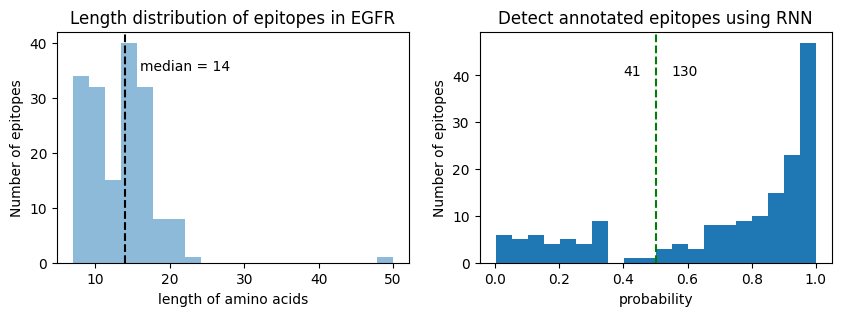

In [349]:
epi_seq = [i['seq'] for i in epitopes.values()]
epi_seq = list(set(epi_seq))
print('number of epitopes:', len(epi_seq))

epi_pred = p.predict(epi_seq)
epi_pred['len'] = epi_pred['text'].apply(lambda x: len(x))

fig, ax = plt.subplots(1, 2, figsize=(10,3))

i=0
ax[i].hist(epi_pred['len'], bins=20, alpha=.5)
ax[i].set_title(f'Length distribution of epitopes in EGFR')
ax[i].set_xlabel('length of amino acids')
ax[i].set_ylabel('Number of epitopes')
med = int(np.median(epi_pred['len']))
ax[i].axvline(med, linestyle='--', c='black')
ax[i].text(16, 35, s=f"median = {med}")

i=1
ax[i].hist(epi_pred['predict'], bins=20)
ax[i].set_title('Detect annotated epitopes using RNN')
ax[i].set_xlabel('probability')
ax[i].set_ylabel('Number of epitopes')
ax[i].axvline(.5, linestyle='--', c='green')
ax[i].text(0.55, 40, s=len(epi_pred[epi_pred['predict']>=0.5]))
ax[i].text(0.40, 40, s=len(epi_pred[epi_pred['predict']<0.5]))

plt.show()

In [ ]:
# label with true epitopes
epi = np.zeros(len(pro_seq))
for item in epitopes.values():
    a, b = item['start']-1, item['end']
    epi[a:b] = 1

Text(0, 0.5, 'Probability on average')

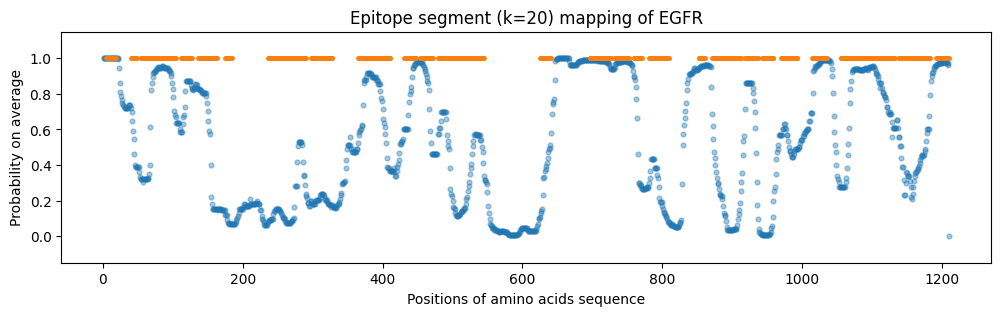

In [436]:
def scan_epitopes(processor, pro_seq, k:int, step:int):
    segments, start, end = [], [], []
    for i in range(0, len(pro_seq) - k, step):
        start.append(i)
        end.append(i+k)
        segments.append(pro_seq[i:i+k])
    num_segments = len(segments)
    # print(num_segments, segments[:2])
    
    # predict
    pred_df = processor.predict(segments)
    # label epitopes by prediction
    pred = [[] for _ in range(len(pro_seq))]
    for a,b,c in zip(start, end, pred_df['predict']):
        for i in range(a,b):
            pred[i].append(c)
    return pred

k, step = 20, 1
prob_k = scan_epitopes(p, pro_seq, k=k, step=step)
pred = pd.DataFrame({
    'pos': range(1, len(pro_seq)+1),
    'epi': epi,
    'prob': [np.median(i) if i else 0 for i in prob_k],
})

# draw
fig, ax = plt.subplots(1, figsize=(12,3))
ax.scatter(pred['pos'], pred['prob'], s=12, alpha=.4)
ax.set_ylim(-0.15, 1.15)
true_epi = pred[pred['epi']==1]
ax.scatter(true_epi['pos'], true_epi['epi'], s=6, )
ax.set_title(f'Epitope segment (k={k}) mapping of EGFR')
ax.set_xlabel(f'Positions of amino acids sequence')
ax.set_ylabel('Probability on average')

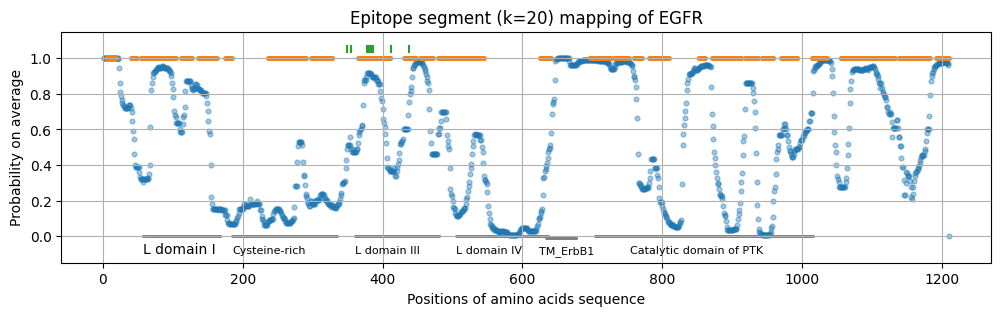

In [437]:
# draw plot with annotations
fig, ax = plt.subplots(1, figsize=(12,3))
ax.scatter(pred['pos'], pred['prob'], s=12, alpha=.4)
ax.set_ylim(-0.15, 1.15)
true_epi = pred[pred['epi']==1]
ax.scatter(true_epi['pos'], true_epi['epi'], s=6, )
ax.set_title(f'Epitope segment (k={k}) mapping of EGFR')
ax.set_xlabel(f'Positions of amino acids sequence')
ax.set_ylabel('Probability on average')

key_aa = [349, 355, 378, 379, 380, 381, 382, 383, 384, 385, 386, 412, 438]
ax.scatter(key_aa, [1.05]*len(key_aa), marker='|')

# https://www.ncbi.nlm.nih.gov/protein/CAA25240.1
# Receptor L domain; pfam01030
a, b = 57, 168
ax.scatter(range(a, b+1), [0]*(b+1-a), s=1, c='grey')
ax.text(a, -0.1, s='L domain I')
a, b = 361, 481
ax.scatter(range(a, b+1), [0]*(b+1-a), s=1, c='grey')
ax.text(a, -0.1, s='L domain III', fontsize=8)
a, b = 505, 637
ax.scatter(range(a, b+1), [0]*(b+1-a), s=1, c='grey')
ax.text(a, -0.1, s='L domain IV', fontsize=8)


# Furin-like cysteine rich region; pfam00757
a, b = 185, 335
ax.scatter(range(a, b+1), [0]*(b+1-a), s=1, c='grey')
ax.text(a, -0.1, s='Cysteine-rich', fontsize=8)
# Transmembrane ErbB1
a, b = 634, 677
ax.scatter(range(a, b+1), [-0.01]*(b+1-a), s=1, c='grey')
ax.text(a-10, -0.1, s='TM_ErbB1', fontsize=8)
# 
a, b = 704, 1016
ax.scatter(range(a, b+1), [0]*(b+1-a), s=1, c='grey')
ax.text(a+50, -0.1, s='Catalytic domain of PTK', fontsize=8)
plt.grid()
plt.show()

In [375]:
# scan with many k-mers
collect_prob = {}
for k in range(6, 50):
    _prob = scan_epitopes(p, pro_seq, k=k, step=1)
    collect_prob[k] = [np.median(i) if i else 0 for i in _prob]

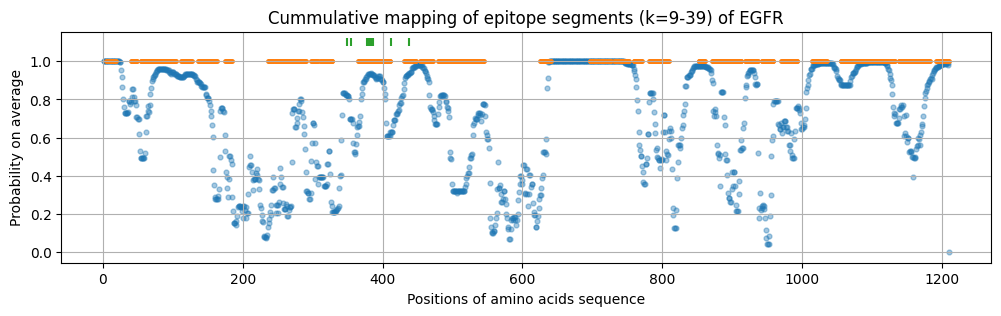

In [379]:
prob_k = pd.DataFrame(collect_prob)
prob_k.apply(lambda x: np.median(x), axis=1)
pred = pd.DataFrame({
    'pos': range(1, len(pro_seq)+1),
    'epi': epi,
    'prob': prob_k.apply(lambda x: np.max(x), axis=1),
})

# draw
fig, ax = plt.subplots(1, figsize=(12,3))
ax.scatter(pred['pos'], pred['prob'], s=12, alpha=.4)
true_epi = pred[pred['epi']==1]
ax.scatter(true_epi['pos'], true_epi['epi'], s=6, )
ax.set_title('Cummulative mapping of epitope segments (k=9-39) of EGFR')
ax.set_xlabel(f'Positions of amino acids sequence')
ax.set_ylabel('Probability on average')

key_aa = [349, 355, 378, 379, 380, 381, 382, 383, 384, 385, 386, 412, 438]
ax.scatter(key_aa, [1.1]*len(key_aa), marker='|')
plt.grid()
plt.show()